# Favor Polar Bin 3 Monomers & Sequences Plots

Analysis notebook for producing publication figures.
- Produces bar chart of upper bin top 10 monomer species for three runs
- Produces bar chart of upper bin top 10 sequences for three runs

## User Input

In [1]:
# path to analysis files
run_file_n = 'n/full_analysis_data_fixed.csv'
run_file_co = 'co/full_analysis_data_fixed.csv'
run_file_cf3 = 'cf3/full_analysis_data_fixed.csv'


run_name_n = 'Amino/Nitro'
plot_color_n = '#50d63d'

run_name_co = 'Methoxy/Cyano'
plot_color_co = '#c1666b'

run_name_cf3 = 'Dimethyl Amino/Trifluoromethyl'
plot_color_cf3 = '#4394f0'

## Imports

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.constants as sc

## Methods

In [3]:
# takes dataframe with cols: run, gen, filename, alpha, mu, vol
# returns dataframe with cols: run, gen, filename, alpha_term, mu_term, vol

def convert_to_clausius_terms(df):
    df2 = pd.DataFrame()

    # loop over rows
    for x in range(df.shape[0]):

        # alpha in bohr^3, mu in debye, vol in A^3
        run = df.iloc[x, 0]
        gen = df.iloc[x,1]
        filename = df.iloc[x, 2]
        alpha = df.iloc[x,3]
        mu = df.iloc[x,4]
        vol = df.iloc[x,5]

        # convert polarizability (volume) to SI units (bohr^3 to m^3)    
        si_alpha_prime = alpha * (5.29177E-11)**3

        # convert dipole moment to SI units (debye to C*m)
        # 1 debye = 3.3E-30 C*m
        si_mu = mu * 3.3356E-30

        # convert volume to SI units (A^3 to m^3)
        si_vol = vol * 1E-30

        # define molecular density N/V (assume packing of 68%)
        n_v = 0.68/si_vol    

        # calculate Clausius-Mossotti equation term values (assume temperature of 300K)
        a_term = n_v * (si_alpha_prime * 4 * sc.pi * sc.epsilon_0)/(3 * sc.epsilon_0)
        m_term = n_v * (si_mu**2)/(9 * sc.epsilon_0 * sc.Boltzmann * 300)

        claus_sum = a_term + m_term

        # solve C-M eqn for dielectric constant
#         dielec = (2 * claus_sum + 1)/(1 - claus_sum)

        temp_df = pd.DataFrame({'run':[run], 'gen':[gen], 'filename':[filename], 'alpha_term':[a_term], 'mu_term':[m_term], 'vol':[vol]})
        df2 = df2.append(temp_df, ignore_index=True)

    return df2

In [4]:
# helper function for top_ten
# takes any dataframe with col: filename
# returns new dataframe with additional cols: mono1, mono2, seq

def split_filename(df):
    df2 = df.copy()

    new = df2['filename'].str.split('_', expand=True)
    df2['mono1'] = new[0]
    df2['mono2'] = new[1]
    df2['seq'] = new[2]
    
    return df2

In [5]:
# takes any dataframe with cols: gen, alpha_term, mu_term
# returns dataframe with same cols, only rows that fell in "top bin"

# note: top bin is the upper right half of data divided at median
def get_top_bin_data(df):
    # horizontal boundary between top bin and bottom bin
    median = df['alpha_term'].median()
   
    # make top bin dataframe    
    top_bin = df[df['alpha_term'] >= median]
    top_bin = top_bin.reset_index(drop=True)

    return(top_bin)

In [6]:
# takes any dataframe with cols: mono1, mono2, seq
# returns list of 2 new dataframes with cols: [x_mono, x_mono_count, x_mono_perc] and [x_seq, x_seq_count, x_seq_perc] 
# where x is specified df_name

# removes any 'false' monomer instances in homopolymers (e.g. mono1 with seq '111111')

def get_bin_counts(df, df_name):

    # split filename column
    df_split = split_filename(df)
    
    # replace 'false' monomer instances in homopolymers (e.g. mono1 with seq '111111') with 'x'
    df_split.loc[df_split['seq'].eq('000000'), 'mono1'] = 'x'
    df_split.loc[df_split['seq'].eq('111111'), 'mono2'] = 'x'

    # make series objects of each part of filename with accompanying counts
    # note that both monomer columns are combined before creating series with value counts
    count_mono = df_split[['mono1', 'mono2']].unstack().reset_index(drop=True).value_counts()
    count_seq = df_split['seq'].value_counts()
    
    # make series objects into dataframes and rename columns appropriately
    count_mono = pd.DataFrame(count_mono.reset_index())
    count_mono.columns = ['%s_mono' % df_name, '%s_mono_count' % df_name]

    count_seq = pd.DataFrame(count_seq.reset_index())
    count_seq.columns = ['%s_seq' % df_name, '%s_seq_count' % df_name]
    
    # remove monomer 'x' row from dataframe
    count_mono = count_mono[count_mono['%s_mono' % df_name] != 'x'].reset_index(drop=True)
    
    # make percentage column in each dataframe  
    count_mono['%s_mono_perc' % df_name] = count_mono['%s_mono_count' % df_name]/count_mono['%s_mono_count' % df_name].sum()*100
    count_seq['%s_seq_perc' % df_name] = count_seq['%s_seq_count' % df_name]/count_seq['%s_seq_count' % df_name].sum()*100

    return [count_mono, count_seq]  

## Data Processing

Make DF of run data  
NOTE: Within generations, polymers are listed from best ranked to worst ranked

In [7]:
run_data_n = pd.read_csv(run_file_n)
run_data_co = pd.read_csv(run_file_co)
run_data_cf3 = pd.read_csv(run_file_cf3)

In [8]:
run_data_cf3.tail()

,run,gen,filename,alpha,mu,vol
12795,1,400,714_463_000010,815.157678,18.759,913.048670
12796,1,400,714_927_000100,828.938861,20.287,930.096072
12797,1,400,749_98_101000,818.142230,8.432,935.048057
12798,1,400,676_98_100010,824.790574,15.312,1026.066357
12799,1,400,1153_98_110000,1677.411114,18.530,2202.712130


Make DF run data with calculated Clausius-Mossotti terms and dielectric constant

In [9]:
run_terms_n = convert_to_clausius_terms(run_data_n)
run_terms_co = convert_to_clausius_terms(run_data_co)
run_terms_cf3 = convert_to_clausius_terms(run_data_cf3)

In [10]:
run_terms_n.tail()

,run,gen,filename,alpha_term,mu_term,vol
12795,1,400,714_1094_011011,0.390442,6.068416,924.564118
12796,1,400,1191_1188_000100,0.368250,0.533350,935.302482
12797,1,400,187_98_100000,0.365529,2.492616,637.344694
12798,1,400,525_426_000010,0.356329,17.874998,1327.306852
12799,1,400,329_1094_000000,0.318437,4.578627,500.640521


In [11]:
top_n = get_top_bin_data(run_terms_n)
top_co = get_top_bin_data(run_terms_co)
top_cf3 = get_top_bin_data(run_terms_cf3)

top_mcounts_n, top_scounts_n = get_bin_counts(top_n, 'top')
top_mcounts_co, top_scounts_co = get_bin_counts(top_co, 'top')
top_mcounts_cf3, top_scounts_cf3 = get_bin_counts(top_cf3, 'top')

top_mcounts_n = top_mcounts_n[:10]
top_mcounts_co = top_mcounts_co[:10]
top_mcounts_cf3 = top_mcounts_cf3[:10]

top_scounts_n = top_scounts_n[:10]
top_scounts_co = top_scounts_co[:10]
top_scounts_cf3 = top_scounts_cf3[:10]

In [12]:
top_mcounts_cf3

,top_mono,top_mono_count,top_mono_perc
0,714,5856,47.081524
1,98,4440,35.697057
2,426,975,7.838881
3,1127,762,6.126387
4,904,175,1.406979
5,924,88,0.707509
6,708,73,0.586911
7,964,36,0.289436
8,1188,6,0.048239
9,635,3,0.024120


## Generate Plots

Set global font sizes for plotting

In [13]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

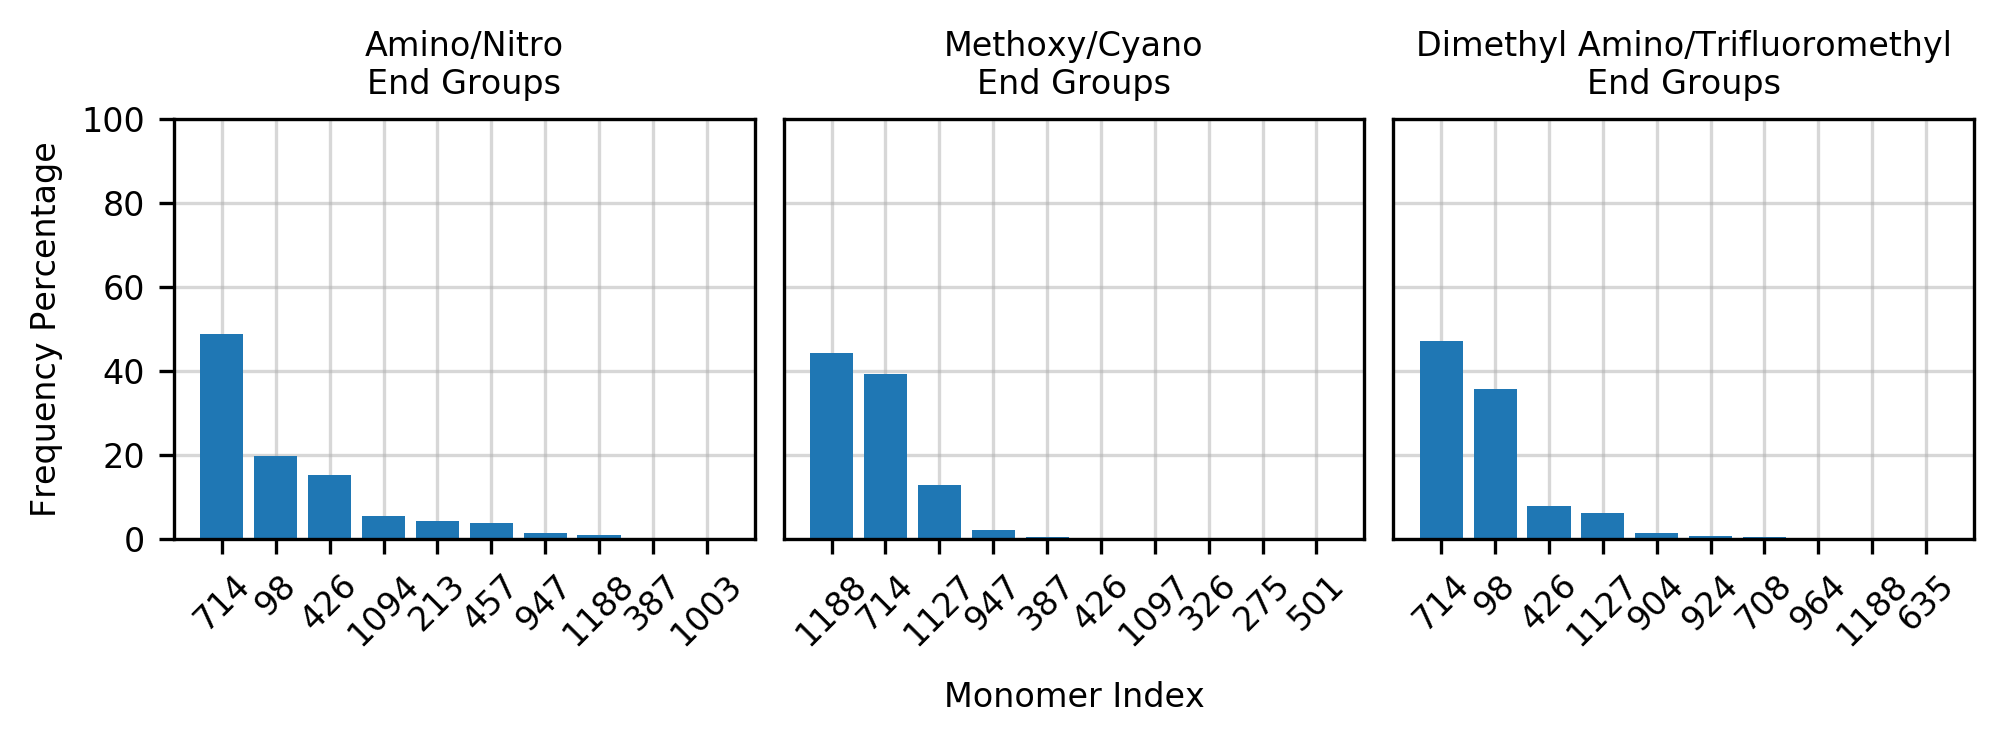

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, dpi=300)

rot=45
wt='bold'

axs[0].bar('top_mono', 'top_mono_perc', data=top_mcounts_n)
axs[0].set_title('%s\nEnd Groups' % run_name_n)
axs[0].set_xticklabels(top_mcounts_n['top_mono'], rotation=rot)
axs[0].set(ylim=(0, 100))

axs[0].grid(alpha=0.5)
axs[0].set_axisbelow(True)

axs[1].bar('top_mono', 'top_mono_perc', data=top_mcounts_co)
axs[1].set_title('%s\nEnd Groups' % run_name_co)
axs[1].set_xticklabels(top_mcounts_co['top_mono'], rotation=rot)

axs[1].grid(alpha=0.5)
axs[1].set_axisbelow(True)

for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

axs[2].bar('top_mono', 'top_mono_perc', data=top_mcounts_cf3)
axs[2].set_title('%s\nEnd Groups' % run_name_cf3)
axs[2].set_xticklabels(top_mcounts_cf3['top_mono'], rotation=rot)

axs[2].grid(alpha=0.5)
axs[2].set_axisbelow(True)

for tic in axs[2].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    
top = 0.5
bottom = 0.15
left = 0
right = 1

fig.text((left+right)/2, 0.01,'Monomer Index', ha='center')
fig.text(-0.08, (top+bottom)/2,'Frequency Percentage', va='center', rotation='vertical')

plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.55, wspace=0.05)

# plt.savefig('favor_polar_monomers.png', transparent=False, bbox_inches='tight')

plt.show()


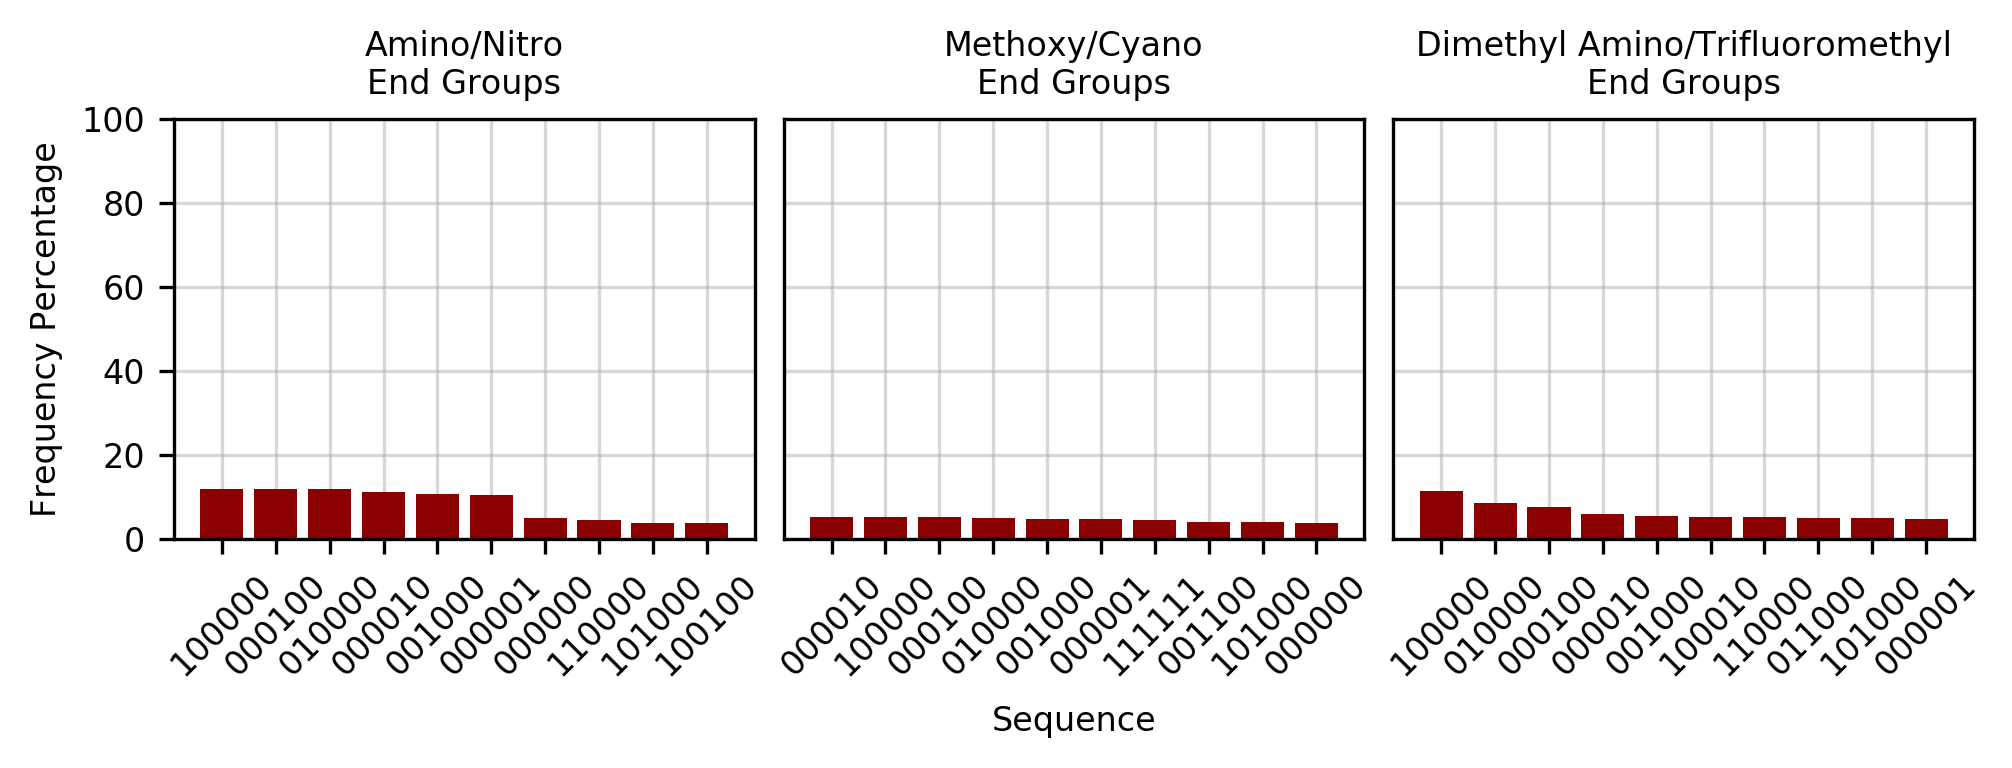

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, dpi=300)

rot=45
wt='bold'
clr = 'darkred'

axs[0].bar('top_seq', 'top_seq_perc', data=top_scounts_n, color=clr)
axs[0].set_title('%s\nEnd Groups' % run_name_n)
axs[0].set_xticklabels(top_scounts_n['top_seq'], rotation=rot)
axs[0].set(ylim=(0, 100))

axs[0].grid(alpha=0.5)
axs[0].set_axisbelow(True)

axs[1].bar('top_seq', 'top_seq_perc', data=top_scounts_co, color=clr)
axs[1].set_title('%s\nEnd Groups' % run_name_co)
axs[1].set_xticklabels(top_scounts_co['top_seq'], rotation=rot)

axs[1].grid(alpha=0.5)
axs[1].set_axisbelow(True)

for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

axs[2].bar('top_seq', 'top_seq_perc', data=top_scounts_cf3, color=clr)
axs[2].set_title('%s\nEnd Groups' % run_name_cf3)
axs[2].set_xticklabels(top_scounts_cf3['top_seq'], rotation=rot)

axs[2].grid(alpha=0.5)
axs[2].set_axisbelow(True)

for tic in axs[2].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

top = 0.5
bottom = 0.15
left = 0
right = 1

fig.text((left+right)/2, -0.01,'Sequence', ha='center')
fig.text(-0.08, (top+bottom)/2,'Frequency Percentage', va='center', rotation='vertical')

plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.55, wspace=0.05)

plt.savefig('favor_polar_sequences.pdf', transparent=False, bbox_inches='tight')
plt.savefig('favor_polar_sequences.png', transparent=False, bbox_inches='tight')

plt.show()
